In [1]:
import pydicom
import os

In [2]:
import sys
import datetime
import time
import shutil
import subprocess
import numpy as np
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from inference.UNetInferenceAgent import UNetInferenceAgent

In [113]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [109]:
dir(matplotlib)

['ExecutableNotFoundError',
 'LooseVersion',
 'MatplotlibDeprecationWarning',
 'MutableMapping',
 'Parameter',
 'Path',
 'RcParams',
 'URL_REGEX',
 '_DATA_DOC_APPENDIX',
 '_DATA_DOC_TITLE',
 '_ExecInfo',
 '__bibtex__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_add_data_doc',
 '_all_deprecated',
 '_check_versions',
 '_cm',
 '_cm_listed',
 '_color_data',
 '_constrained_layout',
 '_create_tmp_config_or_cache_dir',
 '_deprecated_ignore_map',
 '_deprecated_map',
 '_deprecated_remain_as_none',
 '_ensure_handler',
 '_get_config_or_cache_dir',
 '_get_data_path',
 '_get_executable_info',
 '_get_xdg_cache_dir',
 '_get_xdg_config_dir',
 '_image',
 '_init_tests',
 '_label_from_arg',
 '_layoutbox',
 '_log',
 '_logged_cached',
 '_mathtext_data',
 '_open_file_or_url',
 '_path',
 '_preprocess_data',
 '_pylab_helpers',
 '_rc_params_in_file',
 '_replacer',
 '_text_layout',
 '_version',
 'afm',
 'artis

In [3]:
from utils.utils import med_reshape
PATCH_SIZE = 64

In [4]:
def load_dicom_volume_as_numpy_from_list(dcmlist):
    """Loads a list of PyDicom objects a Numpy array.
    Assumes that only one series is in the array

    Arguments:
        dcmlist {list of PyDicom objects} -- path to directory

    Returns:
        tuple of (3D volume, header of the 1st image)
    """

    # In the real world you would do a lot of validation here
    slices = [np.flip(dcm.pixel_array).T for dcm in sorted(dcmlist, key=lambda dcm: dcm.InstanceNumber)]

    # Make sure that you have correctly constructed the volume from your axial slices!
    hdr = dcmlist[0]

    # We return header so that we can inspect metadata properly.
    # Since for our purposes we are interested in "Series" header, we grab header of the
    # first file (assuming that any instance-specific values will be ighored - common approach)
    # We also zero-out Pixel Data since the users of this function are only interested in metadata
    hdr.PixelData = None
    return (np.stack(slices, 2), hdr)

In [5]:
def get_series_for_inference(path):
    """Reads multiple series from one folder and picks the one
    to run inference on.

    Arguments:
        path {string} -- location of the DICOM files

    Returns:
        Numpy array representing the series
    """

    # Here we are assuming that path is a directory that contains a full study as a collection
    # of files
    # We are reading all files into a list of PyDicom objects so that we can filter them later
    dicoms = [pydicom.dcmread(os.path.join(path, f)) for f in os.listdir(path)]

    # TASK: create a series_for_inference variable that will contain a list of only 
    # those PyDicom objects that represent files that belong to the series that you 
    # will run inference on.
    # It is important to note that radiological modalities most often operate in terms
    # of studies, and it will most likely be on you to establish criteria for figuring 
    # out which one of the multiple series sent by the scanner is the one you need to feed to 
    # your algorithm. In our case it's rather easy - we have reached an agreement with 
    # people who configured the HippoCrop tool and they label the output of their tool in a 
    # certain way. Can you figure out which is that? 
    # Hint: inspect the metadata of HippoCrop series

    # <YOUR CODE HERE>
    series_for_inference = [_d for _d in dicoms if _d.SeriesDescription == 'HippoCrop']
    # Check if there are more than one series (using set comprehension).
    if len({f.SeriesInstanceUID for f in series_for_inference}) != 1:
        print("Error: can not figure out what series to run inference on")
        return []
    return series_for_inference

In [6]:
def get_predicted_volumes(pred):
    """Gets volumes of two hippocampal structures from the predicted array

    Arguments:
        pred {Numpy array} -- array with labels. Assuming 0 is bg, 1 is anterior, 2 is posterior

    Returns:
        A dictionary with respective volumes
    """

    # TASK: Compute the volume of your hippocampal prediction
    # <YOUR CODE HERE>
    volume_ant = np.sum(pred == 2)
    volume_post = np.sum(pred == 1)
    total_volume = volume_ant + volume_post
    return {"anterior": volume_ant, "posterior": volume_post, "total": total_volume}

In [7]:
def create_report(inference, header, orig_vol, pred_vol):
    """Generates an image with inference report

    Arguments:
        inference {Dictionary} -- dict containing anterior, posterior and full volume values
        header {PyDicom Dataset} -- DICOM header
        orig_vol {Numpy array} -- original volume
        pred_vol {Numpy array} -- predicted label

    Returns:
        PIL image
    """

    # The code below uses PIL image library to compose an RGB image that will go into the report
    # A standard way of storing measurement data in DICOM archives is creating such report and
    # sending them on as Secondary Capture IODs (http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_A.8.html)
    # Essentially, our report is just a standard RGB image, with some metadata, packed into 
    # DICOM format. 

    pimg = Image.new("RGB", (1000, 1000))
    draw = ImageDraw.Draw(pimg)

    header_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=40)
    main_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=20)

    slice_nums = [orig_vol.shape[2]//3, orig_vol.shape[2]//2, orig_vol.shape[2]*3//4] # is there a better choice?

    # TASK: Create the report here and show information that you think would be relevant to
    # clinicians. A sample code is provided below, but feel free to use your creative 
    # genius to make if shine. After all, the is the only part of all our machine learning 
    # efforts that will be visible to the world. The usefulness of your computations will largely
    # depend on how you present them.

    # SAMPLE CODE BELOW: UNCOMMENT AND CUSTOMIZE
    draw.text((10, 0), "HippoVolume.AI", (255, 255, 255), font=header_font)
    #<WHAT OTHER INFORMATION WOULD BE RELEVANT?>
    draw.multiline_text((10, 90),
                        f"Patient ID:    {header.PatientID}\nPatient Name:    {header.PatientName}\nModality:    {header.Modality}\nSeries Description:    {header.SeriesDescription}\nAnterior Volume:    {inference['anterior']}\nPosterior Volume:    {inference['posterior']}\nTotal Volume:    {inference['total']}",
                        (255, 255, 255), font=main_font)

    # STAND-OUT SUGGESTION:
    # In addition to text data in the snippet above, can you show some images?
    # Think, what would be relevant to show? Can you show an overlay of mask on top of original data?
    # Hint: here's one way to convert a numpy array into a PIL image and draw it inside our pimg object:
    #
    # Create a PIL image from array:
    # Numpy array needs to flipped, transposed and normalized to a matrix of values in the range of [0..255]
#     _image = orig_vol[:,:,slice_nums[0]]
#     _label = pred_vol[:,:,slice_nums[0]]
#     nd_img = np.flip((_image/np.max(_image))*0xff).T.astype(np.uint8)
#     nd_label = np.flip((_label/np.max(_label))*0xff).T.astype(np.uint8)
#     # This is how you create a PIL image from numpy array
#     pil_i = Image.fromarray(nd_img, mode="L").convert("RGBA").resize(pimg.size)
#     pil_pred = Image.fromarray(nd_label, mode="L").convert("RGBA").resize(pimg.size)
#     # Paste the PIL image into our main report image object (pimg)
#     pimg.paste(pil_i, box=(50, 300))
#     pimg.paste(pil_pred, box=(550, 300))
#     return pimg
    orig_vol = med_reshape(orig_vol, (orig_vol.shape[0], PATCH_SIZE, PATCH_SIZE))
    
    position = [10, 350, 690]
    
    for i in range(len(slice_nums)):
        
        nd_img = np.flip((orig_vol[:, :, slice_nums[i]]/np.max(orig_vol[:, :, slice_nums[i]]))*0xff).T.astype(np.uint8)

        pil_i = Image.fromarray(nd_img, mode="L").convert("RGB").resize((300, 400))
        
        nd_pred = np.flip((pred_vol[:, :, slice_nums[i]]/np.max(pred_vol[:, :, slice_nums[i]]))*0xff).T.astype(np.uint8)
        slice_p = pred_vol[:, :, slice_nums[i]]
        
        gr_r = list(nd_pred.ravel())
        
        gr_g = [0] * nd_pred.shape[0] * nd_pred.shape[1]
        
        gr_b = [0] * nd_pred.shape[0] * nd_pred.shape[1]
        
        alpha = np.zeros(nd_pred.shape[0] * nd_pred.shape[1])
        
        alpha[nd_pred.ravel() != 0] = 125
        
        alpha = list(alpha.astype(np.uint8))
        
        img_p = Image.new("RGBA", slice_p.shape)
        
        img_p.putdata(list(zip(gr_r, gr_g, gr_b, alpha)))
        
        img_p = img_p.resize((300, 400))
        
        pil_i.paste(img_p, (0,0), img_p)
        
        pimg.paste(pil_i, box=(position[i], 250))
    return pimg

In [9]:
def save_report_as_dcm(header, report, path):
    """Writes the supplied image as a DICOM Secondary Capture file

    Arguments:
        header {PyDicom Dataset} -- original DICOM file header
        report {PIL image} -- image representing the report
        path {Where to save the report}

    Returns:
        N/A
    """

    # Code below creates a DICOM Secondary Capture instance that will be correctly
    # interpreted by most imaging viewers including our OHIF
    # The code here is complete as it is unlikely that as a data scientist you will 
    # have to dive that deep into generating DICOMs. However, if you still want to understand
    # the subject, there are some suggestions below

    # Set up DICOM metadata fields. Most of them will be the same as original file header
    out = pydicom.Dataset(header)

    out.file_meta = pydicom.Dataset()
    out.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    # STAND OUT SUGGESTION: 
    # If you want to understand better the generation of valid DICOM, remove everything below
    # and try writing your own DICOM generation code from scratch.
    # Refer to this part of the standard to see what are the requirements for the valid
    # Secondary Capture IOD: http://dicom.nema.org/medical/dicom/2019e/output/html/part03.html#sect_A.8
    # The Modules table (A.8-1) contains a list of modules with a notice which ones are mandatory (M)
    # and which ones are conditional (C) and which ones are user-optional (U)
    # Note that we are building an RGB image which would have three 8-bit samples per pixel
    # Also note that writing code that generates valid DICOM has a very calming effect
    # on mind and body :)

    out.is_little_endian = True
    out.is_implicit_VR = False

    # We need to change class to Secondary Capture
    out.SOPClassUID = "1.2.840.10008.5.1.4.1.1.7"
    out.file_meta.MediaStorageSOPClassUID = out.SOPClassUID

    # Our report is a separate image series of one image
    out.SeriesInstanceUID = pydicom.uid.generate_uid()
    out.SOPInstanceUID = pydicom.uid.generate_uid()
    out.file_meta.MediaStorageSOPInstanceUID = out.SOPInstanceUID
    out.Modality = "OT"  # Other
    out.SeriesDescription = "HippoVolume.AI"

    out.Rows = report.height
    out.Columns = report.width

    out.ImageType = r"DERIVED\PRIMARY\AXIAL"  # We are deriving this image from patient data
    out.SamplesPerPixel = 3  # we are building an RGB image.
    out.PhotometricInterpretation = "RGB"
    out.PlanarConfiguration = 0  # means that bytes encode pixels as R1G1B1R2G2B2... as opposed to R1R2R3...G1G2G3...
    out.BitsAllocated = 8  # we are using 8 bits/pixel
    out.BitsStored = 8
    out.HighBit = 7
    out.PixelRepresentation = 0

    # Set time and date
    dt = datetime.date.today().strftime("%Y%m%d")
    tm = datetime.datetime.now().strftime("%H%M%S")
    out.StudyDate = dt
    out.StudyTime = tm
    out.SeriesDate = dt
    out.SeriesTime = tm

    out.ImagesInAcquisition = 1

    # We empty these since most viewers will then default to auto W/L
    out.WindowCenter = ""
    out.WindowWidth = ""

    # Data imprinted directly into image pixels is called "burned in annotation"
    out.BurnedInAnnotation = "YES"

    out.PixelData = report.tobytes()
    pydicom.filewriter.dcmwrite(path, out, write_like_original=False)

In [10]:
dicom_path = os.path.abspath(os.path.join(*['..', 'data']))

In [11]:
subdirs = [os.path.join(dicom_path, d) for d in os.listdir(dicom_path) if
                os.path.isdir(os.path.join(dicom_path, d))]

In [12]:
subdirs

['G:\\MOOC\\Udacity\\NanoDegree AI for healthcare\\Applying AI to 3D Medical Imaging Data\\Hippocampal Volume Quantication in Alzheimers Progression\\section3\\data\\11_HCropVolume']

In [13]:
study_dir = sorted(subdirs, key=lambda dir: os.stat(dir).st_mtime, reverse=True)[0]
print(f"Looking for series to run inference on in directory {study_dir}...")

Looking for series to run inference on in directory G:\MOOC\Udacity\NanoDegree AI for healthcare\Applying AI to 3D Medical Imaging Data\Hippocampal Volume Quantication in Alzheimers Progression\section3\data\11_HCropVolume...


In [14]:
study_dir

'G:\\MOOC\\Udacity\\NanoDegree AI for healthcare\\Applying AI to 3D Medical Imaging Data\\Hippocampal Volume Quantication in Alzheimers Progression\\section3\\data\\11_HCropVolume'

In [15]:
dicoms = [pydicom.dcmread(os.path.join(study_dir, f)) for f in os.listdir(study_dir)]

In [16]:
dicoms[0]

(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20200121'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.67704434286396306053776990229124802376
(0008, 0020) Study Date                          DA: '20200121'
(0008, 0021) Series Date                         DA: '20200121'
(0008, 0030) Study Time                          TM: '004946'
(0008, 0031) Series Time                         TM: '004946'
(0008, 0050) Accession Number                    SH: '3083564386975476'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study Description                   LO: ''
(0008, 103e) Series Description                  LO: 'HippoCrop'
(0010, 0010) Patient's Name                   

In [17]:
dir(dicoms[0])

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'Columns',
 'FrameOfReferenceUID',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'ImagesInAcquisition',
 'InstanceCreationDate',
 'InstanceNumber',
 'Manufacturer',
 'Modality',
 'PatientID',
 'PatientName',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'PositionReferenceIndicator',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDate',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SeriesTime',
 'SliceThickness',
 'StudyDate',
 'StudyDescription',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'WindowCenter',
 'WindowWidth',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 

In [18]:
dicoms[0].SeriesDescription

'HippoCrop'

In [19]:
set([_d.SeriesDescription for _d in dicoms])

{'HippoCrop'}

In [20]:
lst = get_series_for_inference(study_dir)
len(lst)

40

In [21]:
volume, header = load_dicom_volume_as_numpy_from_list(get_series_for_inference(study_dir))
print(f"Found series of {volume.shape[2]} axial slices")

Found series of 40 axial slices


In [22]:
set([_v.shape for _v in volume])

{(50, 40)}

In [23]:
print("HippoVolume.AI: Running inference...")
# TASK: Use the UNetInferenceAgent class and model parameter file from the previous section
inference_agent = UNetInferenceAgent(
    device="cpu",
    parameter_file_path=os.path.abspath(os.path.join(*['.', 'model', 'model.pth'])))

HippoVolume.AI: Running inference...


In [24]:
%load_ext autoreload
%autoreload
from inference.UNetInferenceAgent import UNetInferenceAgent

In [25]:
# Run inference
    # TASK: single_volume_inference_unpadded takes a volume of arbitrary size 
    # and reshapes y and z dimensions to the patch size used by the model before 
    # running inference. Your job is to implement it.
pred_label = inference_agent.single_volume_inference_unpadded(np.array(volume))

In [26]:
pred_label.shape

(34, 64, 64)

In [27]:
pred_label.sum()

5889.0

In [28]:
pred_volumes = get_predicted_volumes(pred_label)

In [29]:
pred_volumes

{'anterior': 1994, 'posterior': 1901, 'total': 3895}

In [30]:
# Create and save the report
print("Creating and pushing report...")
report_file_name = f'report_{time.strftime("%Y-%m-%d_%H%M", time.localtime())}.dcm'
report_save_path = os.path.abspath(os.path.join(*['..', 'out', report_file_name]))

Creating and pushing report...


In [31]:
# report_save_path = os.path.join(*['..', 'out', 'report'])

In [32]:
report_save_path

'G:\\MOOC\\Udacity\\NanoDegree AI for healthcare\\Applying AI to 3D Medical Imaging Data\\Hippocampal Volume Quantication in Alzheimers Progression\\section3\\out\\report_2021-03-08_1901.dcm'

In [33]:
# TASK: create_report is not complete. Go and complete it.
# STAND OUT SUGGESTION: save_report_as_dcm has some suggestions if you want to expand your
# knowledge of DICOM format
report_img = create_report(pred_volumes, header, volume, pred_label)

In [46]:
volume.shape

(34, 50, 40)

In [47]:
pred_label.shape

(34, 64, 64)

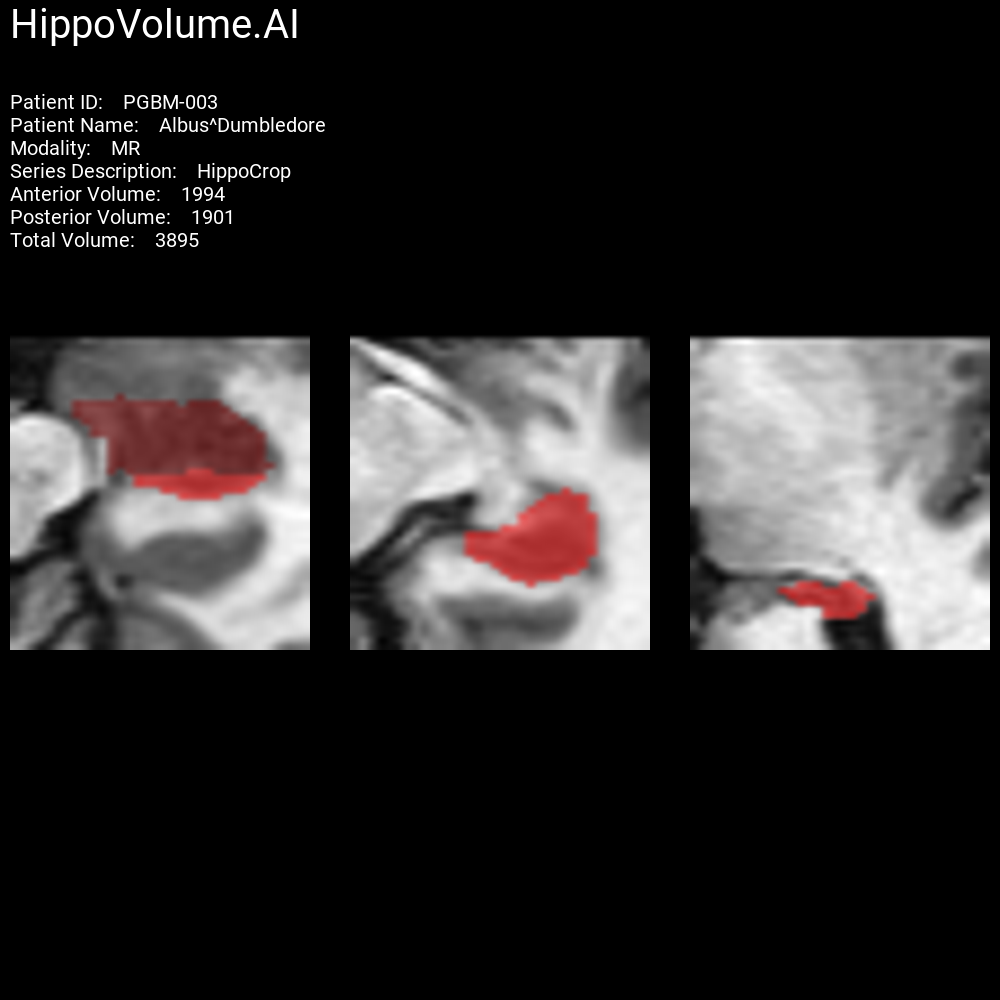

In [34]:
report_img

In [35]:
save_report_as_dcm(header, report_img, report_save_path)

In [214]:
def create_report2(inference, header, orig_vol, pred_vol):
    """Generates an image with inference report

    Arguments:
        inference {Dictionary} -- dict containing anterior, posterior and full volume values
        header {PyDicom Dataset} -- DICOM header
        orig_vol {Numpy array} -- original volume
        pred_vol {Numpy array} -- predicted label

    Returns:
        PIL image
    """
    # The code below uses PIL image library to compose an RGB image that will go into the report
    # A standard way of storing measurement data in DICOM archives is creating such report and
    # sending them on as Secondary Capture IODs (http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_A.8.html)
    # Essentially, our report is just a standard RGB image, with some metadata, packed into 
    # DICOM format. 

    pimg = Image.new("RGB", (1000, 1000))
    draw = ImageDraw.Draw(pimg)

    header_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=40)
    main_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=20)
    # TASK: Create the report here and show information that you think would be relevant to
    # clinicians. A sample code is provided below, but feel free to use your creative 
    # genius to make if shine. After all, the is the only part of all our machine learning 
    # efforts that will be visible to the world. The usefulness of your computations will largely
    # depend on how you present them.

    # SAMPLE CODE BELOW: UNCOMMENT AND CUSTOMIZE
    draw.text((10, 0), "HippoVolume.AI", (255, 255, 255), font=header_font)
    #<WHAT OTHER INFORMATION WOULD BE RELEVANT?>
    draw.multiline_text((10, 90),
                        f"Patient ID:    {header.PatientID}\nPatient Name:    {header.PatientName}\nModality:    {header.Modality}\nSeries Description:    {header.SeriesDescription}",
                        (255, 255, 255), font=main_font)
    draw.multiline_text((500, 90),
                    f"Anterior Volume:    {inference['anterior']}\nPosterior Volume:    {inference['posterior']}\nTotal Volume:    {inference['total']}",
                    (255, 255, 255), font=main_font)

    # STAND-OUT SUGGESTION:
    # In addition to text data in the snippet above, can you show some images?
    # Think, what would be relevant to show? Can you show an overlay of mask on top of original data?
    # Hint: here's one way to convert a numpy array into a PIL image and draw it inside our pimg object:
    #
    # Create a PIL image from array:
    # Numpy array needs to flipped, transposed and normalized to a matrix of values in the range of [0..255]
    # This is how you create a PIL image from numpy array
    # Paste the PIL image into our main report image object (pimg)
    # orig_vol = med_reshape(orig_vol, (orig_vol.shape[0], PATCH_SIZE, PATCH_SIZE))
    slice_nums = [orig_vol.shape[2]//4, orig_vol.shape[2]//2, orig_vol.shape[2]*3//4]  # is there a better choice? # choose 1/4, 2/4, 3.4 for visulization
    resize_factor = 5
    x, y, z = orig_vol.shape
    pred_vol = pred_vol[:x, :y, :z]  # resize to the original size
    rows = [300, 500, 700]
    cols = [50, 350, 650]
    for i, v in enumerate(slice_nums):
        _image = orig_vol[:, :, slice_nums[i]]
        _label = pred_vol[:, :, slice_nums[i]]
        nd_img = np.flip((_image/np.max(_image)) * 0xff).T.astype(np.uint8)
        nd_label = np.flip(_label).T.astype(np.uint8)
        target_size = tuple([nd_img.shape[0] * resize_factor,nd_img.shape[1] * resize_factor])
        pil_i = Image.fromarray(nd_img, mode="L").convert("RGBA").resize(target_size)
        pil_pred = Image.fromarray(nd_label, mode="P").resize(target_size)
        pil_pred.putpalette([100, 100, 100, 255, 0, 0, 0, 255, 0])   # red for 1 and green for 2
        pil_pred = pil_pred.convert("RGBA")
        pil_2 = Image.blend(pil_i, pil_pred, 0.3)
        figures = [pil_i, pil_pred, pil_2]
        for j in range(3):
            pimg.paste(figures[j], box=(cols[j], rows[i]))
    return pimg

In [228]:
def create_report(inference, header, orig_vol, pred_vol):
    """Generates an image with inference report

    Arguments:
        inference {Dictionary} -- dict containing anterior, posterior and full volume values
        header {PyDicom Dataset} -- DICOM header
        orig_vol {Numpy array} -- original volume
        pred_vol {Numpy array} -- predicted label

    Returns:
        PIL image
    """
    # The code below uses PIL image library to compose an RGB image that will go into the report
    # A standard way of storing measurement data in DICOM archives is creating such report and
    # sending them on as Secondary Capture IODs (http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_A.8.html)
    # Essentially, our report is just a standard RGB image, with some metadata, packed into
    # DICOM format.

    pimg = Image.new("RGB", (1000, 1000))
    draw = ImageDraw.Draw(pimg)

    header_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=40)
    main_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=20)
    # TASK: Create the report here and show information that you think would be relevant to
    # clinicians. A sample code is provided below, but feel free to use your creative 
    # genius to make if shine. After all, the is the only part of all our machine learning 
    # efforts that will be visible to the world. The usefulness of your computations will largely
    # depend on how you present them.

    # SAMPLE CODE BELOW: UNCOMMENT AND CUSTOMIZE
    draw.text((10, 0), "HippoVolume.AI", (255, 255, 255), font=header_font)
    #<WHAT OTHER INFORMATION WOULD BE RELEVANT?>
    draw.multiline_text((10, 90),
                        f"Patient ID:    {header.PatientID}\nPatient Name:    {header.PatientName}\nModality:    {header.Modality}\nSeries Description:    {header.SeriesDescription}",(255, 255, 255), font=main_font)
    slice_nums = [orig_vol.shape[2] // 4, orig_vol.shape[2] // 2, orig_vol.shape[2] * 3 // 4]  # is there a better choice? 
    # choose 1/4, 2/4, 3.4 for visulization
    draw.multiline_text((500, 90),
                    f"Anterior Volume:    {inference['anterior']}\nPosterior Volume:    {inference['posterior']}\nTotal Volume:    {inference['total']}\nSlices:    {slice_nums[0]}, {slice_nums[1]}, {slice_nums[2]}",(255, 255, 255), font=main_font)

    # STAND-OUT SUGGESTION:
    # In addition to text data in the snippet above, can you show some images?
    # Think, what would be relevant to show? Can you show an overlay of mask on top of original data?
    # Hint: here's one way to convert a numpy array into a PIL image and draw it inside our pimg object:
    #
    # Create a PIL image from array:
    # Numpy array needs to flipped, transposed and normalized to a matrix of values in the range of [0..255]
    # This is how you create a PIL image from numpy array
    # Paste the PIL image into our main report image object (pimg)
    # orig_vol = med_reshape(orig_vol, (orig_vol.shape[0], PATCH_SIZE, PATCH_SIZE))

    resize_factor = 5
    x, y, z = orig_vol.shape
    pred_vol = pred_vol[:x, :y, :z]  # resize pred_vol to the original size
    rows = [300, 500, 700]
    cols = [50, 350, 650]

    for i, v in enumerate(slice_nums):
        _image = orig_vol[:, :, slice_nums[i]]
        _label = pred_vol[:, :, slice_nums[i]]
        nd_img = np.flip((_image / np.max(_image)) * 0xff).T.astype(np.uint8)
        nd_label = np.flip(_label).T.astype(np.uint8)
        target_size = tuple([nd_img.shape[0] * resize_factor,nd_img.shape[1] * resize_factor])
        pil_i = Image.fromarray(nd_img, mode="L").convert("RGBA").resize(target_size)
        pil_pred = Image.fromarray(nd_label, mode="P").resize(target_size)
        pil_pred.putpalette([100, 100, 100, 255, 0, 0, 0, 255, 0])   # red for 1 and green for 2
        pil_pred = pil_pred.convert("RGBA")
        pil_2 = Image.blend(pil_i, pil_pred, 0.3) # blend 2 images
        figures = [pil_i, pil_pred, pil_2]
        for j in range(3):
            pimg.paste(figures[j], box=(cols[j], rows[i]))
    return pimg

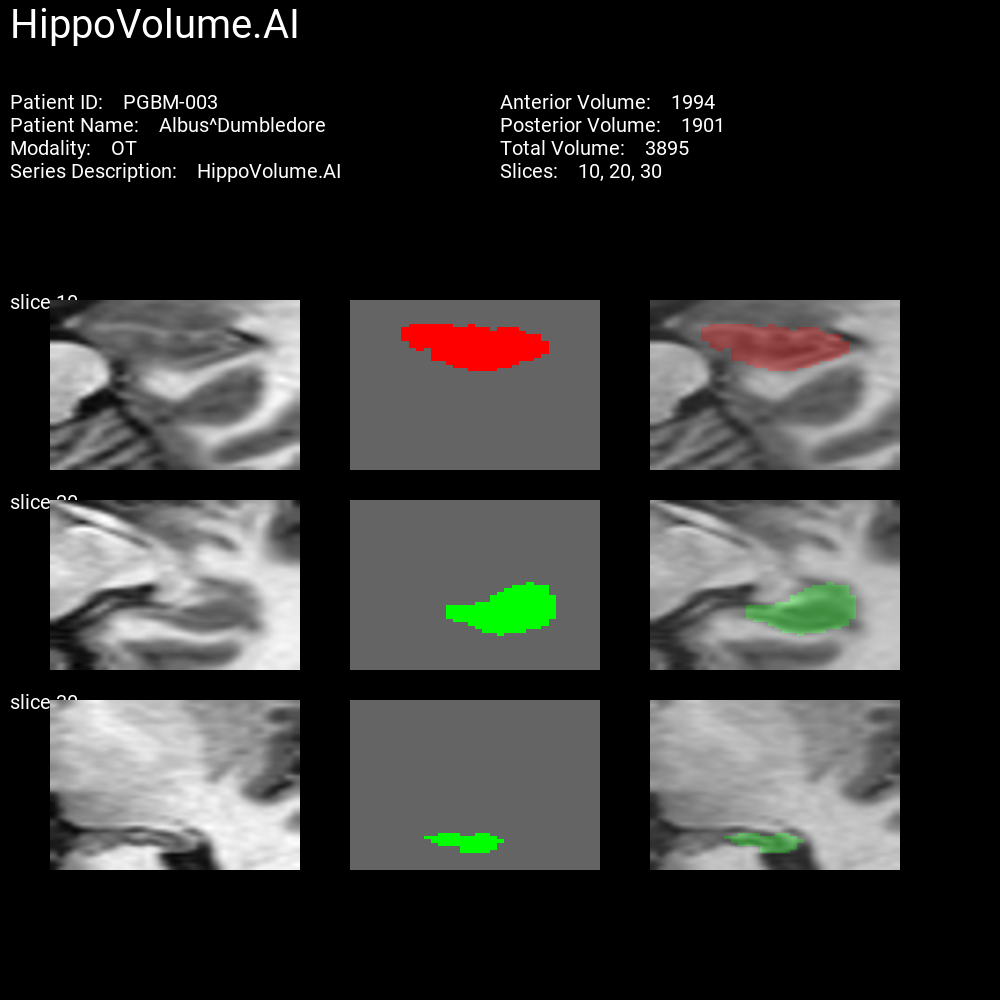

In [229]:
report_img3 = create_report(pred_volumes, header, volume, pred_label)
report_img3

In [94]:
x, y, z = volume.shape
label = pred_label[:x, :y, :z]

In [148]:
label.shape

(34, 50, 40)

In [149]:
slice_label = label[:, :, z // 2]

In [150]:
slice_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [182]:
slice_label.sum()

296

In [174]:
def gray_to_rgb(image):
    """
    convert labels to rgb image
    """
    rgb_image = np.zeros([4, image.shape[0], image.shape[1]])
#     image = np.
    rgb_image[0, :, :] = (image == 1) * 255
    rgb_image[1, :, :] = (image == 2) * 255
    return rgb_image

In [190]:
img = Image.fromarray(slice_label, mode="P")
img.putpalette([255, 255, 255,255, 0, 0, 0, 255, 0])
img.show()

In [192]:
type(img)

PIL.Image.Image

In [193]:
img2 = img.convert('RGBA')

In [194]:
type(img2)

PIL.Image.Image

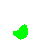

In [195]:
img2

In [176]:
k = Image.fromarray(rgb_image, mode="RGBA")

In [181]:
k

In [163]:
k.ravel()

array([0., 0., 0., 0.])